In [4]:
from data import *
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd

import os
import os.path as osp
import sys
import time

import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision as tv
import torch.optim as optim

import torch.utils.data as data
import torchvision.datasets

import numpy as np
from PIL import Image
import argparse

from matplotlib import pyplot as plt
import pandas as pd
import cv2 
import pickle as pkl
import random
import tarfile
import collections
import math
import datetime
import pickle

from opts import *
import xml.etree.ElementTree as ET

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.zero_()

In [5]:
def train(device, resume=None, lr=1e-3):
    
    #initialize config
    cfg = voc
    dataset = VOCDetection(root=dataset_root, image_sets=[('2012', 'train')],
                            transform=SSDAugmentation(cfg['min_dim'],
                             MEANS))
    ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
    net = ssd_net
    
    if train_device:
        net = torch.nn.DataParallel(ssd_net)
        torch.backends.cudnn.benchmark = True
        net = net.to(train_device)
        
    if resume:
        print('Resuming training, loading previous training at ',resume)
        ssd_net.load_weights(resume) 
    else:
        vgg_weights = torch.load(basenet)
        print('Loading base network...')
        ssd_net.vgg.load_state_dict(vgg_weights)
        print('Initializing weights...')
        ssd_net.extras.apply(weights_init)
        ssd_net.loc.apply(weights_init)
        ssd_net.conf.apply(weights_init)

    optimizer = optim.SGD(net.parameters(), lr, momentum,weight_decay)
    
    criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                             False, torch.cuda.is_available())

    
    net.train()
    name = 'train'
    
    # loss counters
    loc_loss = 0
    conf_loss = 0
    epoch = 0
    print('Loading the dataset...')

    epoch_size = len(dataset) // batch_size
    print('Training SSD on: ',name)

    step_index = 0


    train_data_loader = data.DataLoader(dataset, batch_size=32, num_workers=4, shuffle=True,\
                               collate_fn=detection_collate,pin_memory=True)
    
    print("Number of images in the training set = " + str(len(dataset)))
    print("Number of images in a mini-batch = "+str(batch_size))
    print("Number of mini-batches = " + str(len(train_data_loader)))
    
    
     # create batch iterator
    batch_iterator = iter(train_data_loader)
    print("STARTING - ITERATIONS")
    
    # Stats for pickle and plotting
    l_loss = []
    c_loss = []
    itr = []
    
    for iteration in range(0, 250):
        
        if iteration != 0 and (iteration % epoch_size == 0):
            # reset epoch loss counters
            loc_loss = 0
            conf_loss = 0
            epoch += 1

        if iteration in cfg['lr_steps']:
            step_index += 1
            lr_dec = lr * (gamma ** (step_index))
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_dec

            
        ## load train data
        try:
            images, targets = next(batch_iterator)
        except StopIteration:
            batch_iterator = iter(train_data_loader)
            images, targets = next(batch_iterator)


        
        if train_device:
            images = images.cuda()
            targets = [ann.cuda() for ann in targets]
        else:
            images = images
            targets = [ann for ann in targets]
        
        # forward
        t0 = time.time()
        out = net(images)

        # backprop
        optimizer.zero_grad()

        loss_l, loss_c = criterion(out, targets)
        loss = loss_l + loss_c

        loss.backward()

        optimizer.step()

        t1 = time.time()
        loc_loss += loss_l.data.item()
        conf_loss += loss_c.data.item()

        l_loss.append(loss_l.data.item())
        c_loss.append(loss_c.data.item())
        itr.append(iteration)
        
        if iteration % 10 == 0:
            print('timer: %.4f sec.' % (t1 - t0))
            print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.data.item()), end=' ')
            currentDT = datetime.datetime.now()
            print (currentDT.strftime("%H:%M:%S %p"))
            print("\n")

        
        if iteration != 0 and iteration % 10 == 0:
            print('Saving state, iter:', iteration)
            iter_name = math.ceil(iteration/100)*100
            torch.save(ssd_net.state_dict(), 'weights/ssd_VOC_' + str(lr) + +repr(iter_name) + '.pth')
            with open('stats_' + str(lr) + '.pkl','wb') as f:
                pkl.dump([l_loss, c_loss, itr], f)
                

    torch.save(ssd_net.state_dict(),
               save_folder + data_set + '.pth') 

In [15]:
for lr in [1e-2]:
    train(lr)

Loading base network...
Initializing weights...
Loading the dataset...
Training SSD on:  train
Number of images in the training set = 5717
Number of images in a mini-batch = 32
Number of mini-batches = 179
STARTING - ITERATIONS


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 48.7876 sec.
iter 0 || Loss: 25.7996 || 09:54:23 AM


timer: 1.9053 sec.
iter 10 || Loss: nan || 09:55:57 AM


Saving state, iter: 10
timer: 1.9081 sec.
iter 20 || Loss: nan || 09:59:15 AM


Saving state, iter: 20
timer: 2.3055 sec.
iter 30 || Loss: nan || 10:01:47 AM


Saving state, iter: 30
timer: 2.6028 sec.
iter 40 || Loss: nan || 10:05:00 AM


Saving state, iter: 40
timer: 1.9974 sec.
iter 50 || Loss: nan || 10:07:17 AM


Saving state, iter: 50
timer: 1.0360 sec.
iter 60 || Loss: nan || 10:10:30 AM


Saving state, iter: 60
timer: 1.4993 sec.
iter 70 || Loss: nan || 10:12:58 AM


Saving state, iter: 70
timer: 1.7078 sec.
iter 80 || Loss: nan || 10:16:10 AM


Saving state, iter: 80
timer: 2.2856 sec.
iter 90 || Loss: nan || 10:18:30 AM


Saving state, iter: 90
timer: 2.7011 sec.
iter 100 || Loss: nan || 10:21:45 AM


Saving state, iter: 100
timer: 2.3115 sec.
iter 110 || Loss: nan || 10:24:02 AM


Saving state, iter: 110
timer: 2.4964 sec.
iter 120 || Loss: nan || 10:27:17 AM

KeyboardInterrupt: 

In [16]:
for lr in [1e-5, 1e-1]:
    train(lr)

Loading base network...
Initializing weights...
Loading the dataset...
Training SSD on:  train
Number of images in the training set = 5717
Number of images in a mini-batch = 32
Number of mini-batches = 179
STARTING - ITERATIONS


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 5.0099 sec.
iter 0 || Loss: 27.3770 || 10:32:16 AM


timer: 0.2564 sec.
iter 10 || Loss: 25.7608 || 10:34:35 AM


Saving state, iter: 10
timer: 1.7065 sec.
iter 20 || Loss: 24.7820 || 10:37:44 AM


Saving state, iter: 20
timer: 0.8036 sec.
iter 30 || Loss: 23.4662 || 10:40:35 AM


Saving state, iter: 30
timer: 3.3984 sec.
iter 40 || Loss: 22.0296 || 10:43:32 AM


Saving state, iter: 40
timer: 1.3995 sec.
iter 50 || Loss: 20.8593 || 10:46:12 AM


Saving state, iter: 50
timer: 3.0030 sec.
iter 60 || Loss: 19.6608 || 10:49:10 AM


Saving state, iter: 60
timer: 0.2526 sec.
iter 70 || Loss: 18.4195 || 10:51:37 AM


Saving state, iter: 70
timer: 2.6023 sec.
iter 80 || Loss: 17.6898 || 10:54:50 AM


Saving state, iter: 80
timer: 1.7936 sec.
iter 90 || Loss: 16.5436 || 10:57:20 AM


Saving state, iter: 90
timer: 2.6012 sec.
iter 100 || Loss: 16.0404 || 11:00:15 AM


Saving state, iter: 100
timer: 0.2534 sec.
iter 110 || Loss: 15.7764 || 11:02:39 AM


Saving state, iter: 110
timer: 1.801

KeyboardInterrupt: 

In [ ]:
for lr in [1e-4]:
    train(lr)

Loading base network...
Initializing weights...
Loading the dataset...
Training SSD on:  train
Number of images in the training set = 5717
Number of images in a mini-batch = 32
Number of mini-batches = 179
STARTING - ITERATIONS


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:95: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 2.5968 sec.
iter 0 || Loss: 25.8962 || 12:19:59 PM


timer: 1.4073 sec.
iter 10 || Loss: 19.3669 || 12:22:48 PM


Saving state, iter: 10
timer: 2.0908 sec.
iter 20 || Loss: 15.8268 || 12:27:07 PM


Saving state, iter: 20
timer: 1.1920 sec.
iter 30 || Loss: 15.4345 || 12:30:12 PM


Saving state, iter: 30
timer: 0.6099 sec.
iter 40 || Loss: 15.2886 || 12:34:37 PM


Saving state, iter: 40
timer: 1.5994 sec.
iter 50 || Loss: 14.9479 || 12:37:27 PM


Saving state, iter: 50
timer: 1.1191 sec.
iter 60 || Loss: 14.4285 || 12:41:39 PM


Saving state, iter: 60
timer: 1.8091 sec.
iter 70 || Loss: 14.2184 || 12:44:34 PM


Saving state, iter: 70
timer: 1.9037 sec.
iter 80 || Loss: 13.6424 || 12:48:38 PM


Saving state, iter: 80
timer: 1.3128 sec.
iter 90 || Loss: 13.4067 || 12:51:34 PM


Saving state, iter: 90
timer: 1.5038 sec.
iter 100 || Loss: 12.7301 || 12:55:28 PM


Saving state, iter: 100
timer: 1.0911 sec.
iter 110 || Loss: 11.9487 || 12:58:09 PM


Saving state, iter: 110
timer: 1.814

Text(0, 0.5, 'Loss')

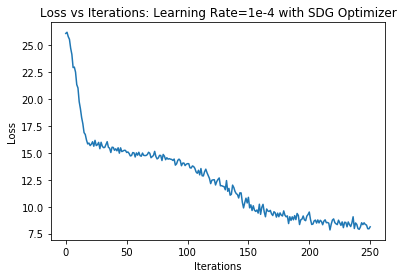

In [5]:
with open('optimization_experiments/pickles/stats_0.0001.pkl','rb') as f:
    l_loss, c_loss, itr = pickle.load(f)

l_loss = np.asarray(l_loss)
c_loss = np.asarray(c_loss)
itr = np.asarray(itr)
plt.plot(itr,l_loss+c_loss)
plt.title('Loss vs Iterations: Learning Rate=1e-4 with SDG Optimizer')
plt.xlabel('Iterations')
plt.ylabel('Loss')